# Enhancing Broadcast Operations with Real-Time Pitch Classification: A Case Study on Kevin Gausman

**Sahil Sangani**

---
embed-resources: true
echo: false
---

## Introduction

The purpose of this report is to explore the use of machine learning for automatic pitch type classification in real time. As Major League Baseball continues to integrate advanced analytics into its broadcasts, providing instant insights—such as identifying a pitch type immediately after it is thrown—offers an opportunity to enhance the fan viewing experience. This project focuses on leveraging data-driven approaches to make these insights more accurate and accessible.

Using pitch-level data from Kevin Gausman’s 2024 season that includes velocity, spin rate, horizontal and vertical movement, and batter stance, this report develops and evaluates models to determine whether these features can reliably predict the type of pitch thrown. The analysis aims to identify an accurate and efficient model that could serve as the foundation for a scalable, real-time pitch recognition system in MLB broadcasts.

## Methods

In [718]:
# imports
import pandas as pd         # for loading data
from joblib import dump     # for exporting the model

# machine learning
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# vizualizations
import matplotlib.pyplot as plt
import seaborn as sns

### Data

The dataset contains pitch-level observations from Kevin Gausman’s 2024 and 2025 MLB regular season games, where each observation represents a single pitch. Pitches from 2024 are used for training, while those from the first half of 2025 form the test set. The target variable is the pitch type, and features include release speed, release spin rate, horizontal movement, vertical movement, and batter stance. The original source of the data is Statcast, accessed through the pybaseball package via Baseball Savant’s Statcast Search. A full list of pitch type abbreviations and their meanings can be found [here](https://beanumber.github.io/abdwr3e/C_statcast.html#tbl-pitchTypes).

In [719]:
# Load data, using the given code on lab.cs307.org
pitches_train = pd.read_parquet(
    "https://lab.cs307.org/pitches/data/pitches-train.parquet",
)
pitches_test = pd.read_parquet(
    "https://lab.cs307.org/pitches/data/pitches-test.parquet",
)

In [720]:
# Examine the DataFrame
pitches_train.head()

,pitch_type,release_speed,release_spin_rate,pfx_x,pfx_z,stand
0,FF,97.3,2432.0,-0.80,1.61,L
1,FF,97.9,2385.0,-0.93,1.22,L
2,FF,96.6,2390.0,-0.97,1.38,L
3,FS,86.4,1492.0,-1.27,0.50,L
4,FS,88.9,1778.0,-1.14,0.68,R


**`pitch_type`**

- `[object]` the type of the pitch

**`release_speed`**

- `[float64]` pitch velocity (miles per hour) measured shortly after leaving the pitcher's hand

**`release_spin_rate`**

- `[float64]` pitch spin rate (revolutions per minute) measured shortly after leaving the pitcher's hand

**`pfx_x`**

- `[float64]` horizontal movement (feet) of the pitch from the catcher's perspective.

**`pfx_z`**

- `[float64]` vertical movement (feet) of the pitch from the catcher's perspective.

**`stand`**

- `[object]` side of the plate batter is standing, either `L` (left) or `R` (right)

In [721]:
# create X_train and X_test
# create X and y for train
X_train = pitches_train.drop("pitch_type", axis=1)
y_train = pitches_train["pitch_type"]

# create X and y for test
X_test = pitches_test.drop("pitch_type", axis=1)
y_test = pitches_test["pitch_type"]

### Calculate summary statistics

In [722]:
# shape of train data
n_samples = X_train.shape[0]
n_features = X_train.shape[1]
print(f"The train dataset consists of {n_samples} observations")

The train dataset consists of 2868 observations


In [723]:
# target balance
pitch_count = pitches_train['pitch_type'].value_counts()
pitch_count

pitch_type
FF    1488
FS     959
SL     240
SI     181
Name: count, dtype: int64

In [724]:
pitch_prop = pitches_train['pitch_type'].value_counts(normalize=True)
pitch_prop

pitch_type
FF    0.518828
FS    0.334379
SL    0.083682
SI    0.063110
Name: proportion, dtype: float64

@fig-exploratory shows that our data has some imbalance when it comes to the types of pitches thrown. Sinker and slider pitches have much fewer observations than four-seam fastball and split-finger fastball, but this should not be a issue as 181 observations can be enough to capture the patterns.

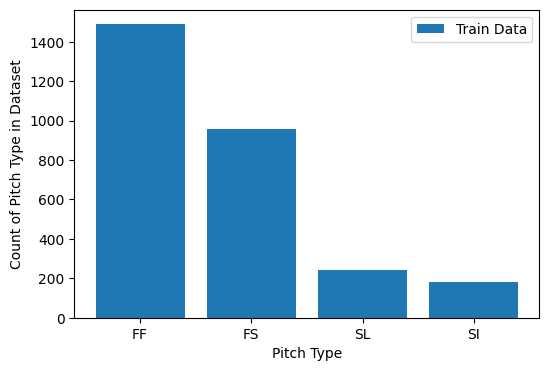

In [725]:
#| echo: false
#| label: fig-exploratory
#| fig-cap: "Distribution of counts by pitch type."
plt.figure(figsize=(6,4))
plt.bar(x=pitch_count.index, height=pitch_count.values, label="Train Data")
plt.xlabel("Pitch Type")
plt.ylabel("Count of Pitch Type in Dataset")
plt.legend()

@fig-boxplot-speed and @fig-boxplot-spin show us the variability in release speed and spin of different pitch types can be useful for classification.

In [726]:
# velocity stats
velocity_stats = pitches_train.groupby("pitch_type")["release_speed"].agg(["mean", "std"])
velocity_stats

,mean,std
pitch_type,,
FF,93.957527,1.700911
FS,85.969552,1.821758
SI,93.310497,1.739876
SL,82.747917,1.864128


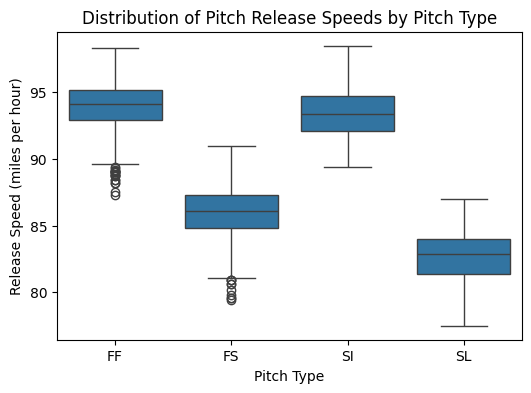

In [727]:
#| echo: false
#| label: fig-boxplot-speed
#| fig-cap: "Varying release speeds of different pitch types."
plt.figure(figsize=(6,4))
sns.boxplot(data=pitches_train, y="release_speed", x="pitch_type")
plt.xlabel("Pitch Type")
plt.ylabel("Release Speed (miles per hour)")
plt.title("Distribution of Pitch Release Speeds by Pitch Type")
plt.show()

In [728]:
# spin stats
spin_stats = pitches_train.groupby("pitch_type")["release_spin_rate"].agg(["mean", "std"])
spin_stats

,mean,std
pitch_type,,
FF,2287.098118,101.983970
FS,1764.038582,177.469770
SI,2189.022099,113.026494
SL,2239.435146,96.452687


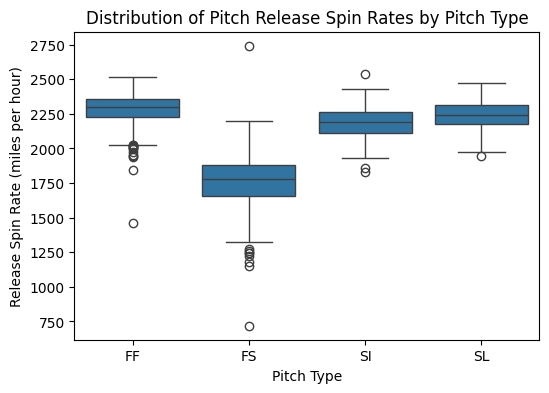

In [729]:
#| echo: false
#| label: fig-boxplot-spin
#| fig-cap: "Varying release spin rates of different pitch types."
plt.figure(figsize=(6,4))
sns.boxplot(data=pitches_train, y="release_spin_rate", x="pitch_type")
plt.xlabel("Pitch Type")
plt.ylabel("Release Spin Rate (miles per hour)")
plt.title("Distribution of Pitch Release Spin Rates by Pitch Type")
plt.show()

From @fig-boxplot_pfx_x and @fig-boxplot_pfx_z, it is evident that certain pitch types are distinct in either release speed, spin rate, or both. For pitch types that show overlap, additional analysis of their movement can help differentiate them further.

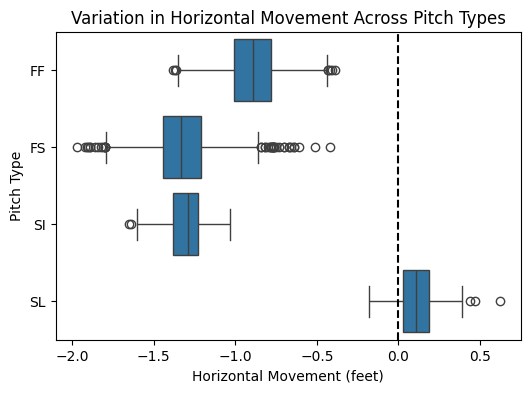

In [730]:
#| echo: false
#| label: fig-boxplot_pfx_x
#| fig-cap: horizontal movement of a pitch type from the catcher’s perspective.
plt.figure(figsize=(6,4))
sns.boxplot(data=pitches_train, x="pfx_x", y="pitch_type")
plt.axvline(0, color="black", linestyle="--")
plt.xlabel("Horizontal Movement (feet)")
plt.ylabel("Pitch Type")
plt.title("Variation in Horizontal Movement Across Pitch Types")
plt.show()

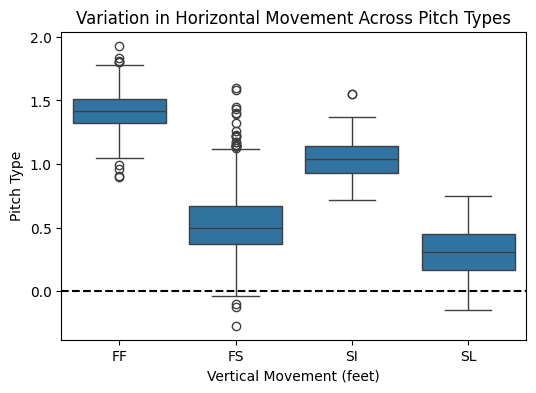

In [731]:
#| echo: false
#| label: fig-boxplot_pfx_z
#| fig-cap: Verticle movement of a pitch type from the catcher’s perspective.
plt.figure(figsize=(6,4))
sns.boxplot(data=pitches_train, x="pitch_type", y="pfx_z")
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Vertical Movement (feet)")
plt.ylabel("Pitch Type")
plt.title("Variation in Horizontal Movement Across Pitch Types")
plt.show()

@fig-movement shows the movement of the pitch from catcher's perspective, this plot gives a better understanding of how movement of the ball can be used to further identify the pitch type

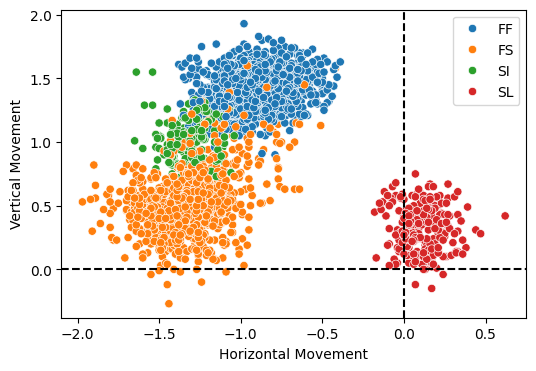

In [732]:
#| echo: false
#| label: fig-movement
#| fig-cap: movement of a pitch from catcher's perspective
plt.figure(figsize=(6,4))
sns.scatterplot(data=pitches_train, x="pfx_x", y="pfx_z", hue="pitch_type")
plt.axvline(0, color="black", linestyle="--")
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Horizontal Movement")
plt.ylabel("Vertical Movement")
plt.legend()
plt.show()

Missing values in training dataset:

In [733]:
# Show NA values
pitches_train.isna().sum()

pitch_type           0
release_speed        0
release_spin_rate    1
pfx_x                0
pfx_z                0
stand                0
dtype: int64

Missing values in test data:

In [734]:
pitches_test.isna().sum()

pitch_type            0
release_speed         0
release_spin_rate     0
pfx_x                44
pfx_z                47
stand                 0
dtype: int64

### Model Development

Train a model using only release_speed as the feature. A preprocessing pipeline is applied to handle missing values and standardize the data: missing values are imputed with the median, and the feature is z-score standardized to ensure it contributes appropriately to the distance metric. The KNN model is trained with k = 3.

In [735]:
# train model on release_speed
features = ["release_speed"]

# define preprocessing
numeric_transformer = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("scalar", StandardScaler())
    ]
)

column_transformer = ColumnTransformer(
    [
        ("numeric", numeric_transformer, features)
    ]
)

In [736]:
model = Pipeline(
    [
        ("preprocessor", column_transformer),
        ("classifier", KNeighborsClassifier(n_neighbors=3))
    ]
)

In [737]:
model

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [738]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [739]:
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

Test Accuracy: 0.867109634551495


The test accuracy we achieved by the model with just "release_speed" is too low, this is as expected as we saw that some pitch types had similar release speeds.

Now let's train a model using all features. A preprocessing pipeline is applied to handle missing values and prepare the data: numeric features are median-imputed and standardized, while the categorical feature is imputed with the most frequent value and one-hot encoded. These steps are combined using a ColumnTransformer before training the KNN model with k = 3.

In [740]:
# train model on all features
numeric_features = ["release_speed", "release_spin_rate", "pfx_x", "pfx_z"]
categorical_features = ["stand"]

# define preprocessing
numeric_transformer = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("scalar", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder())
    ]
)

column_transformer = ColumnTransformer(
    [
        ("numeric", numeric_transformer, numeric_features),
        ("categorical", categorical_transformer, categorical_features)
    ]
)

In [741]:
model = Pipeline(
    [
        ("preprocessor", column_transformer),
        ("classifier", KNeighborsClassifier(n_neighbors=3))
    ]
)
model

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric', ...), ('categorical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [742]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

Test Accuracy: 0.9811738648947951


This model gives a better test accuracy, but we can further improve performance by tuning the number of neighbors (k) in the KNN algorithm. To do this, a grid search is performed over different values of k using 5-fold cross-validation. The GridSearchCV function tests multiple configurations and selects the one that achieves the highest accuracy on the validation folds.

In [743]:
# train model on all features AND evaluate with grid search
param_grid = {
    "classifier__n_neighbors": range(1,101,5)   
}

model_grid = GridSearchCV(
    model,           # model to optimize
    param_grid,      # parameter grid that will be explored
    cv = 5,          # cross validation folds
    scoring="accuracy" # target matric
)

model_grid.fit(X_train, y_train)

,estimator,Pipeline(step...eighbors=3))])
,param_grid,"{'classifier__n_neighbors': range(1, 101, 5)}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('numeric', ...), ('categorical', ...)]"


In [744]:
print(f"Best k: {model_grid.best_params_["classifier__n_neighbors"]}")
print(f"Best cross-validation accuracy: {model_grid.best_score_}")


Best k: 51
Best cross-validation accuracy: 0.9811712911444748


To improve the model’s performance, a grid search with 5-fold cross-validation was used to test different values of k. In cross-validation, the training data is split into several parts, and the model is trained and tested multiple times — this helps get a more reliable estimate of accuracy instead of relying on a single split.

@fig-cv_results shows the mean cross-validation accuracy for each value of k, making the results more robust to random variation in the data. The value of k that gives the highest mean accuracy is selected as the best setting for the final model.

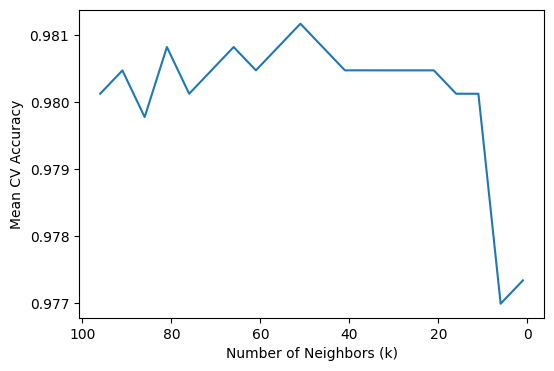

In [ ]:
#| echo: false
#| label: fig-cv_results
#| fig-cap: KNN Accuracy Across Different k Values
df = pd.DataFrame(
    {
        'k': model_grid.cv_results_['param_classifier__n_neighbors'],
        'mean_test_score': model_grid.cv_results_['mean_test_score']
    }
)
plt.figure(figsize=(6,4))
ax = sns.lineplot(data=df, x="k", y="mean_test_score")
ax.invert_xaxis()
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Mean CV Accuracy")
plt.show()  

## Results

In [768]:
# report model metrics
y_pred = model_grid.predict(X_test)
full_model_accuracy = accuracy_score(y_test, y_pred)
print("Best model test accuracy:", full_model_accuracy)

Best model test accuracy: 0.9861572535991141


After tuning with grid search, the best-performing model was a KNN classifier with k = 51. This model achieved a test accuracy of 0.9862, showing strong overall performance in classifying pitch types.

The confusion matrix below illustrates how well the model distinguishes between different pitches. It performs well on four-seam fastballs, split-finger fastballs, and sliders, correctly identifying most of them. However, the model struggles with sinkers, which are often mislabeled as four-seam fastballs. This overlap likely occurs because these two pitches share similar velocity and movement characteristics.

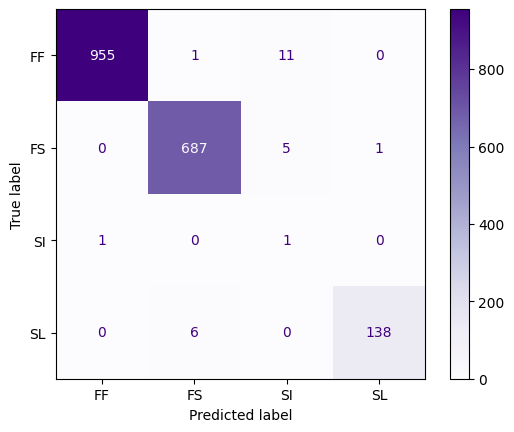

In [749]:
#| label: fig-confusion
#| fig-cap: "Confusion matrix showing misclassified pitch types"

cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
display.plot(cmap="Purples")
plt.show()

Overall, the model demonstrates solid predictive ability and provides useful insights into which pitch types are most and least distinguishable based on the available features.

## Discussion

The conclusion is that this model should **not be used for live MLB broadcasting** in its current form. While the KNN model performs well in classifying four-seam fastballs, split-finger fastballs, and sliders, it frequently mislabels sinkers as fastballs, which could lead to incorrect information being displayed to viewers during broadcasts. In a real-world context, such errors would reduce trust in the system and diminish its value as an analytical tool.

The model’s performance also depends heavily on the specific pitcher and dataset used. Because it was trained only on Kevin Gausman’s data, it may not generalize to other pitchers, pitch types, or environmental conditions. The dataset’s missing values and KNN’s sensitivity to feature scaling and parameter choice further limit reliability.


Despite these issues, the project shows that **real-time pitch recognition using in-game data is feasible**. To make the model viable for real-world use, future work should focus on testing across multiple pitchers, incorporating more features such as release angle or pitch location, and experimenting with more advanced models like random forests or gradient boosting. These improvements could help reduce misclassifications and make the system more accurate and trustworthy for broadcast applications.